In [37]:
import pandas as pd
from rdkit import Chem
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from tabulate import tabulate
from sklearn.cluster import KMeans
from rdkit.Chem import MACCSkeys

In [38]:
df = pd.read_csv('pilot_library.csv')
#display(df)


In [39]:
# Add a column for RDKit molecule objects
df['Molecule'] = df['smiles'].apply(Chem.MolFromSmiles)
df['Fingerprint'] = df['Molecule'].apply(lambda x: MACCSkeys.GenMACCSKeys(x))

In [41]:
def calculate_tanimoto_similarity(fp1, fp2):
    intersection = np.sum(np.logical_and(fp1, fp2))
    union = np.sum(np.logical_or(fp1, fp2))
    if union == 0:
        return 0.0
    else:
        return intersection / union

fingerprints = np.array(df['Fingerprint'].tolist())
similarity_matrix = np.zeros((len(fingerprints), len(fingerprints)))

for i in range(len(fingerprints)):
    for j in range(i, len(fingerprints)):
        tanimoto_similarity = calculate_tanimoto_similarity(fingerprints[i], fingerprints[j])
        similarity_matrix[i, j] = tanimoto_similarity
        similarity_matrix[j, i] = tanimoto_similarity


In [42]:
pca = PCA(n_components=3)
points_2d = pca.fit_transform(similarity_matrix)
pca_df = pd.DataFrame(
    data=points_2d, 
    columns=[
        'Principal Component 1', 
        'Principal Component 2',
        'Principal Component 3'
        ])
display(pca_df)

,Principal Component 1,Principal Component 2,Principal Component 3
0,-8.336604,-1.981653,-1.576075
1,-6.913005,-2.702214,-2.426081
2,-1.097681,-1.535916,-2.499384
3,-2.278038,-1.528366,-2.418288
4,1.824983,-2.607580,-4.561354
...,...,...,...
5011,5.635260,-1.686170,-0.444335
5012,10.788146,-2.371303,-2.907610
5013,0.714801,-0.749375,4.594102
5014,-2.766522,-2.738073,0.016881


In [43]:
num_components_to_display = 3

# Create a DataFrame with principal components and explained variance ratios
components_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(num_components_to_display)],
    'Explained Variance Ratio': pca.explained_variance_ratio_[:num_components_to_display]
})

# tabular format
table = tabulate(components_df, headers='keys', tablefmt='pretty', showindex=False)
print(table)


+---------------------+--------------------------+
| Principal Component | Explained Variance Ratio |
+---------------------+--------------------------+
|         PC1         |    0.5429795017837324    |
|         PC2         |   0.16207510884795576    |
|         PC3         |   0.07555231260686243    |
+---------------------+--------------------------+


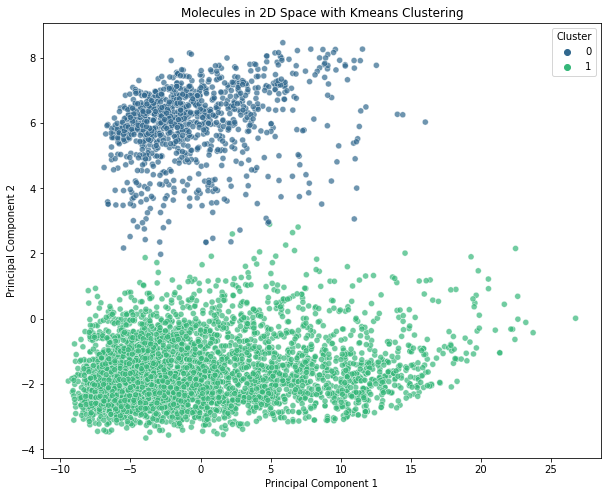

In [44]:
num_clusters = 2 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(fingerprints)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=points_2d[:, 0], y=points_2d[:, 1], hue=df['Cluster'], palette='viridis', alpha=0.7)
plt.title('Molecules in 2D Space with Kmeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

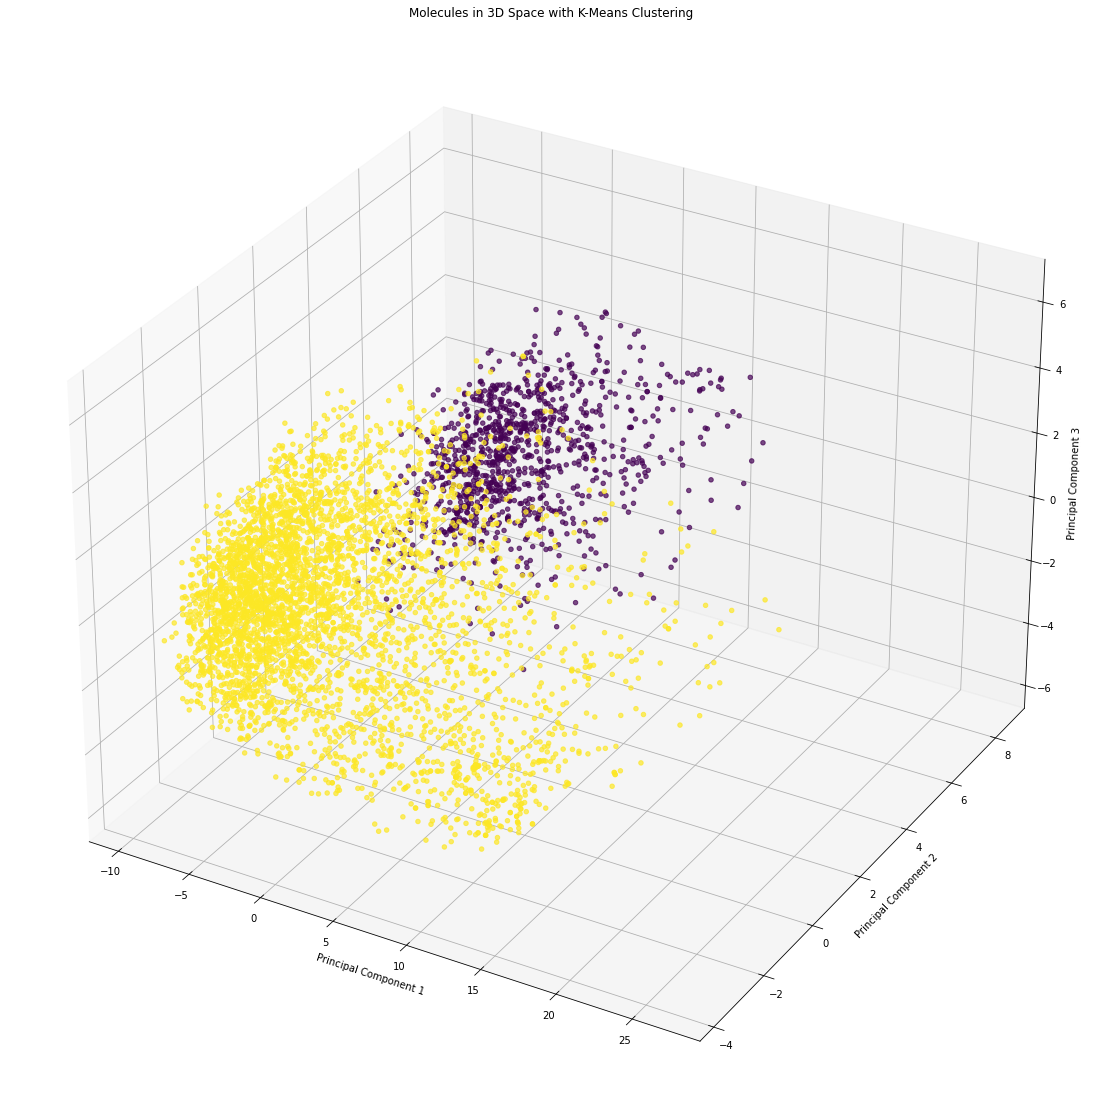

In [45]:
# Apply k-means clustering

num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(fingerprints)

# 3D scatter plot with cluster colors
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Use the first three principal components for x, y, and z axes
ax.scatter(points_2d[:, 0], points_2d[:, 1], points_2d[:, 2], c=df['Cluster'], cmap='viridis', alpha=0.7)

ax.set_title('Molecules in 3D Space with K-Means Clustering')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

plt.show()


In [46]:
df_c = df
df_c = df_c.groupby("Cluster")

display(df_c)
#display(df_c.get_group(5), "\n\n")
